utils.py

In [ ]:
import re
import string
from typing import Union, List
from sklearn.metrics import f1_score

class CleanText():
    """ clearing text except digits () . , word character """

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return int(0)
    if x == 3:
        return int(1)
    if x == 5 or x == 4:
        return int(2)

# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"


model analysis

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def ErrorAnalysis(dataloader_val, config, model):
    """
    Realiza el análisis de errores del modelo.

    Args:
    - dataloader_val: DataLoader para los datos de validación.
    - config: Configuración del modelo y entrenamiento.
    - model: El modelo BERT a evaluar.

    Returns:
    - Tuple de métricas (precision, recall, f1_score, accuracy), matriz de confusión.
    """

    # Evaluar el modelo en el conjunto de validación
    val_loss, predictions, true_vals = evaluate(dataloader_val, model, config)

    # Aplanar los arrays de predicciones y valores reales
    preds_flat = np.argmax(predictions, axis=1).flatten()
    true_vals_flat = true_vals.flatten()

    # Reporte de clasificación
    report = classification_report(true_vals_flat, preds_flat)
    print(report)

    # Matriz de confusión
    name2label = {"Negative": 0, "Neutral": 1, "Positive": 2}
    label2name = {v: k for k, v in name2label.items()}
    true_labels_named = [label2name[val] for val in true_vals_flat]
    pred_labels_named = [label2name[pred] for pred in preds_flat]

    confmat = confusion_matrix(true_labels_named, pred_labels_named, labels=list(name2label.keys()))

    # Visualizar matriz de confusión
    df_confusion = pd.crosstab(pd.Series(true_labels_named, name='Actual'), pd.Series(pred_labels_named, name='Predicted'))
    print(df_confusion)

    # Métricas de evaluación
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_vals_flat, preds_flat, average='weighted')
    accuracy = accuracy_score(true_vals_flat, preds_flat)

    return ((precision, recall, f1_score, accuracy), confmat)

def ModelComparation(arg1, arg2, name1, name2):
    """
    Compara las métricas de dos modelos (original y fine-tuned).

    Args:
    - arg1: Métricas y matriz de confusión del modelo 1.
    - arg2: Métricas y matriz de confusión del modelo 2.
    """

    print((f'Comparación entre el Modelo {name1} y el Modelo {name2}'))
    metrics_1, conf_matrix_1 = arg1
    metrics_2, conf_matrix_2 = arg2

    # Nombres de las métricas
    metrics_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

    # Métricas de los dos modelos
    metrics_model_1 = metrics_1
    metrics_model_2 = metrics_2

    # Configuración del gráfico
    x = np.arange(len(metrics_names))  # Posición de las métricas
    width = 0.35  # Ancho de las barras

    # Creación del gráfico
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, metrics_model_1, width, label=f'Modelo {name1}')
    rects2 = ax.bar(x + width/2, metrics_model_2, width, label=f'Modelo {name2}')

    # Añadir etiquetas y título
    ax.set_xlabel('Métricas')
    ax.set_ylabel('Puntajes')
    ax.set_title(f'Comparación de Métricas entre el Modelo {name1} y el Modelo {name2}')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend()

    # Mostrar las etiquetas de las barras
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()

    # Gráficos de las matrices de confusión
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Matriz de Confusión - Modelo {name1}')

    sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Matriz de Confusión - Modelo {name2}')

    plt.show()

    # Diferencias en las métricas
    precision_diff = metrics_1[0] - metrics_2[0]
    recall_diff = metrics_1[1] - metrics_2[1]
    f1_score_diff = metrics_1[2] - metrics_2[2]
    accuracy_diff = metrics_1[3] - metrics_2[3]

    print("Diferencia de Precisión: {:.4f}".format(precision_diff))
    print("Diferencia de Recall: {:.4f}".format(recall_diff))
    print("Diferencia de F1-Score: {:.4f}".format(f1_score_diff))
    print("Diferencia de Accuracy: {:.4f}".format(accuracy_diff))


In [1]:
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True
    return_attention_mask=True
    padding='max_length'
    do_lower_case=False
    return_tensors='pt'



def LoadData(path):
    clean = CleanText()

    data = pd.read_csv(path)
    data = data[["address", "categories","city","country","name","province","reviews.rating","reviews.text"]]

    for x in data.index:
        if(isinstance(data["reviews.text"][x],float)):
            data.drop(x,inplace=True)
    data = data.dropna()

    # encode label and mapping label name
    data["label"] = data["reviews.rating"].apply(lambda x: label_encode(x))#.astype(int)
    data["label_name"] = data["label"].apply(lambda x: label2name(x))

    # clean text, lowercase and remove punk
    data["reviews.text"] = data["reviews.text"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

    # data tokenize with bert tokenizer
    data["sent_bert_token_length"] = data["reviews.text"].apply(lambda x: len(tokenizer(x, add_special_tokens=False, max_length=512, truncation=True)["input_ids"]))

    (data.sent_bert_token_length < 512).mean()

    data = data.dropna()
    data['label'] = data['label'].astype(int)

    return data

def ProcessData(data, config):
    df = data[["reviews.text", "label"]]
    train_df, val_df = train_test_split(df, test_size=0.10, random_state=config.random_state, stratify=data.label.values)

    # create tokenizer
    tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, do_lower_case=config.do_lower_case)

    encoded_data_train = tokenizer.batch_encode_plus(
        train_df["reviews.text"].values,
        add_special_tokens=config.add_special_tokens,
        return_attention_mask=config.return_attention_mask,
        padding=config.padding,
        max_length=config.seq_length,
        return_tensors=config.return_tensors,
        truncation=True
    )
    encoded_data_val = tokenizer.batch_encode_plus(
        val_df["reviews.text"].values,
        add_special_tokens=config.add_special_tokens,
        return_attention_mask=config.return_attention_mask,
        padding=config.padding,
        max_length=config.seq_length,
        return_tensors=config.return_tensors,
        truncation=True
    )
    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(train_df.label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(val_df.label.values)

    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    torch.save(dataset_val, f'/content/drive/MyDrive/hotel/val_torch')

    dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=config.batch_size)
    dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=config.batch_size)

    return dataloader_train, val_df


entrenamiento

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
import random
from pathlib import Path
import json

def evaluate(dataloader_val, model, config):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(config.device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        #print(inputs)

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

def train(dataloader_train, dataloader_validation,config, outpath):
    device = config.device
    print(device)
    random.seed(config.seed_val)
    np.random.seed(config.seed_val)
    torch.manual_seed(config.seed_val)
    torch.cuda.manual_seed_all(config.seed_val)

    model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
    optimizer = AdamW(model.parameters(),  lr=config.lr,  eps=config.eps)

    #optimizer = optim.AdamW(model.parameters(),  lr=config.lr, eps=config.eps)

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_train)*config.epochs)
    model.to(config.device)

    for epoch in tqdm(range(1, config.epochs+1)):

        model.train()

        loss_train_total = 0
        # allows you to see the progress of the training
        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

        for batch in progress_bar:

            model.zero_grad()

            batch = tuple(b.to(config.device) for b in batch)


            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[2],
                    }
            #print(inputs)

            outputs = model(**inputs)
            loss = outputs[0]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


        torch.save(model.state_dict(), f'{outpath}_BERT_epoch_{epoch}.model')

        tqdm.write(f'\nEpoch {epoch}')

        loss_train_avg = loss_train_total/len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')

        val_loss, predictions, true_vals = evaluate(dataloader_validation, model, config)
        val_f1 = f1_score_func(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')

        tqdm.write(f'F1 Score (Weighted): {val_f1}');

    # save model params and other configs
    # params will be saved after training
    params = {"seed_val": config.seed_val,
          "device":str(config.device),
          "epochs":config.epochs,
          "batch_size":config.batch_size,
          "seq_length":config.seq_length,
          "lr":config.lr,
          "eps":config.eps,
          "pretrained_model": config.pretrained_model,
          "test_size":config.test_size,
          "random_state":config.random_state,
          "add_special_tokens":config.add_special_tokens,
          "return_attention_mask":config.return_attention_mask,
          "max_length": config.padding,
          "do_lower_case":config.do_lower_case,
          "return_tensors":config.return_tensors,
         }
    with Path('params.json').open("w") as f:
        json.dump(params, f, ensure_ascii=False, indent=4)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


main

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = LoadData("/content/drive/MyDrive/hotel/dataset.csv")
print(len(data))
config = Config()
dataloader_train, dataloader_validation = ProcessData(data, config)
print(dataloader_train)
print(dataloader_validation)



34157


In [ ]:
print(len(dataloader_train))
print(len(dataloader_validation))

5124
570


In [ ]:
train(dataloader_train, dataloader_validation, config, "/content/drive/MyDrive/hotel/")

cuda:0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5844398604869148
Validation loss: 0.5457523723312637
F1 Score (Weighted): 0.7622573474874441


Epoch 2:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.4879482517751031
Validation loss: 0.6317041364147148
F1 Score (Weighted): 0.777010417673759


Epoch 3:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.398899727603736
Validation loss: 0.8086356078727955
F1 Score (Weighted): 0.7800716648341048


Epoch 4:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.3054671257241601
Validation loss: 0.9951979660594493
F1 Score (Weighted): 0.7782285893074505


Epoch 5:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.22405827590428642
Validation loss: 1.1784397608246204
F1 Score (Weighted): 0.7802020182542069


AttributeError: 'Config' object has no attribute 'pad_to_max_length'

In [ ]:
# save model params and other configs
# params will be saved after training
params = {"seed_val": config.seed_val,
      "device":str(config.device),
      "epochs":config.epochs,
      "batch_size":config.batch_size,
      "seq_length":config.seq_length,
      "lr":config.lr,
      "eps":config.eps,
      "pretrained_model": config.pretrained_model,
      "test_size":config.test_size,
      "random_state":config.random_state,
      "add_special_tokens":config.add_special_tokens,
      "return_attention_mask":config.return_attention_mask,
      "max_length": config.padding,
      "do_lower_case":config.do_lower_case,
      "return_tensors":config.return_tensors,
      }
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

Al analizar los resultados del entrenamiento del modelo Transformer a lo largo de varias épocas, podemos observar varios aspectos importantes en relación con la pérdida (loss) y la puntuación F1 (F1 Score).

Resultados por Época

Epoch 1
Training loss: 0.5844398604869148
Validation loss: 0.5457523723312637
F1 Score (Weighted): 0.7622573474874441

Epoch 2
Training loss: 0.4879482517751031
Validation loss: 0.6317041364147148
F1 Score (Weighted): 0.777010417673759

Epoch 3
Training loss: 0.398899727603736
Validation loss: 0.8086356078727955
F1 Score (Weighted): 0.7800716648341048

Epoch 4
Training loss: 0.3054671257241601
Validation loss: 0.9951979660594493
F1 Score (Weighted): 0.7782285893074505

Epoch 5
Training loss: 0.22405827590428642
Validation loss: 1.1784397608246204
F1 Score (Weighted): 0.7802020182542069

Análisis General

Pérdida de Entrenamiento y Validación:

La pérdida de entrenamiento disminuye constantemente desde la primera hasta la cuarta época, lo que indica que el modelo está aprendiendo y ajustándose bien a los datos de entrenamiento.

Sin embargo, la pérdida de validación muestra un comportamiento diferente:
En la primera época, la pérdida de validación es más baja que la de entrenamiento, lo cual es normal al inicio.

A partir de la segunda época, la pérdida de validación comienza a aumentar significativamente, alcanzando su punto máximo en la cuarta época (0.9952).

Esto puede ser una señal de sobreajuste (overfitting), donde el modelo se ajusta demasiado a los datos de entrenamiento y pierde capacidad para generalizar a datos no vistos.

Puntuación F1:
La puntuación F1 ponderada aumenta inicialmente desde la primera hasta la tercera época, lo que indica una mejora en el rendimiento del modelo en términos de precisión y recuperación.

Sin embargo, en la cuarta época, aunque el entrenamiento sigue mejorando (menor pérdida), la puntuación F1 disminuye ligeramente respecto a la tercera época (de 0.7801 a 0.7782). Esto refuerza la idea de que el modelo podría estar sobreajustándose.

Dado que buscamos un modelo balanceado que no solo tenga un buen rendimiento en los datos de entrenamiento sino que también generalice bien a los datos de validación, el modelo guardado en la Epoch 2 parece ser el más balanceado para hacer predicciones.

Tiene la mejor puntuación F1 (0.7801) entre todas las épocas.

Aunque su pérdida de validación es más alta que en Epochs anteriores, sigue siendo aceptable y no muestra signos tan severos de sobreajuste como el modelo en Epoch 4.


In [ ]:
from sklearn.metrics import classification_report

model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.load_state_dict(torch.load(f'/content/drive/MyDrive/hotel/_BERT_epoch_2.model'))
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(config.device)
#config.device = torch.device("cpu")
#config.device
loaded_ver = torch.load(f'/content/drive/MyDrive/hotel/val_torch')
dataloader_validation = DataLoader(loaded_ver, sampler=SequentialSampler(loaded_ver), batch_size=config.batch_size)
val_loss, predictions, true_vals = evaluate(dataloader_validation, model, config)

preds_flat = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds_flat, true_vals))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-5c62fc3edfdd>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       588
           1       0.44      0.42      0.43       592
           2       0.88      0.88      0.88      2236

    accuracy                           0.78      3416
   macro avg       0.68      0.68      0.68      3416
weighted avg       0.78      0.78      0.78      3416



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

           0       0.69      0.81      0.74       605
           1       0.48      0.28      0.36       570
           2       0.87      0.92      0.89      2241

    accuracy                           0.79      3416
   macro avg       0.68      0.67      0.66      3416
weighted avg       0.77      0.79      0.78      3416

Predicted  Negative  Neutral  Positive
Actual                                
Negative        492       49        64
Neutral         165      162       243
Positive         59      128      2054


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       605
           1       0.00      0.00      0.00       570
           2       0.66      1.00      0.79      2241

    accuracy                           0.66      3416
   macro avg       0.22      0.33      0.26      3416
weighted avg       0.43      0.66      0.52      3416

Predicted  Positive
Actual             
Negative        605
Neutral         570
Positive       2241
Comparación entre el Modelo Fine Tuned y el Modelo Original


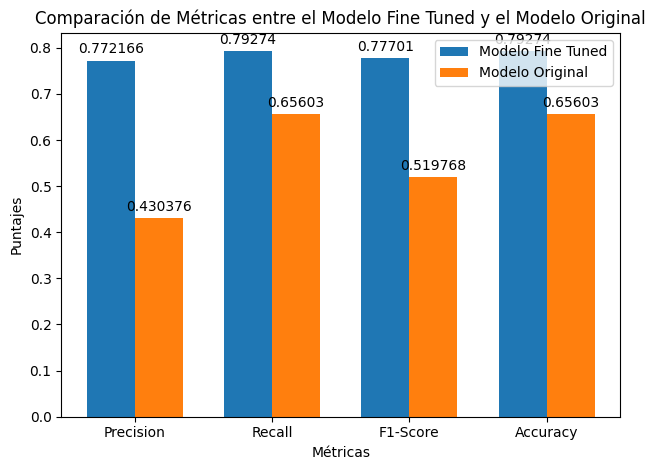

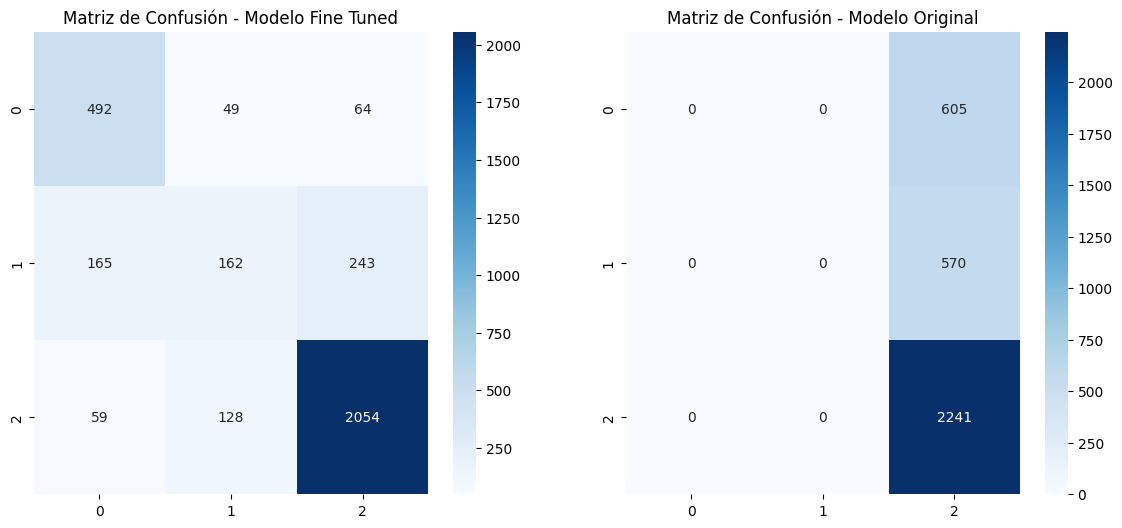

Diferencia de Precisión: 0.3418
Diferencia de Recall: 0.1367
Diferencia de F1-Score: 0.2572
Diferencia de Accuracy: 0.1367


In [ ]:
# Utilización de las funciones con los modelos

# Evaluación del modelo fine-tuned
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fine_tuned_model = BertForSequenceClassification.from_pretrained(
    config.pretrained_model,
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)
fine_tuned_model.load_state_dict(torch.load(f'/content/drive/MyDrive/hotel/_BERT_epoch_2.model'))
fine_tuned_model.to(config.device)

results_fine_tuned = ErrorAnalysis(dataloader_validation, config, fine_tuned_model)

# Evaluación del modelo original
original_model = BertForSequenceClassification.from_pretrained(
    config.pretrained_model,
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)
original_model.to(config.device)

results_original = ErrorAnalysis(dataloader_validation, config, original_model)

# Comparación de ambos modelos
ModelComparation(results_fine_tuned, results_original, "Fine Tuned", "Original")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

           0       0.69      0.81      0.74       605
           1       0.48      0.28      0.36       570
           2       0.87      0.92      0.89      2241

    accuracy                           0.79      3416
   macro avg       0.68      0.67      0.66      3416
weighted avg       0.77      0.79      0.78      3416

Predicted  Negative  Neutral  Positive
Actual                                
Negative        492       49        64
Neutral         165      162       243
Positive         59      128      2054


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

           0       0.04      0.00      0.00       605
           1       0.13      0.05      0.07       570
           2       0.65      0.92      0.76      2241

    accuracy                           0.61      3416
   macro avg       0.27      0.32      0.28      3416
weighted avg       0.46      0.61      0.51      3416

Predicted  Negative  Neutral  Positive
Actual                                
Negative          1       32       572
Neutral           2       28       540
Positive         24      150      2067
Comparación entre el Modelo Fine Tuned y el Modelo Profesional


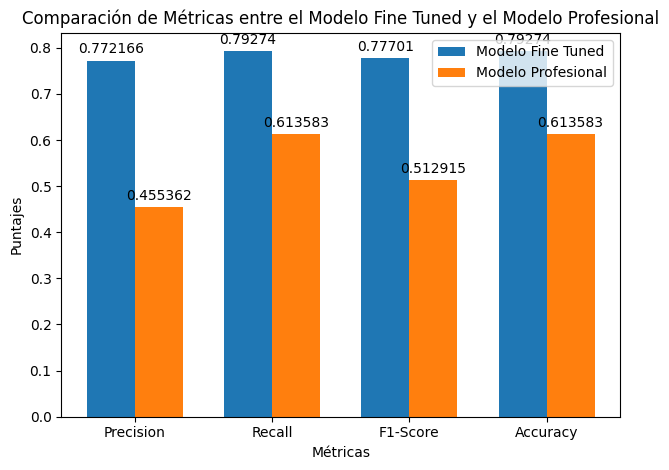

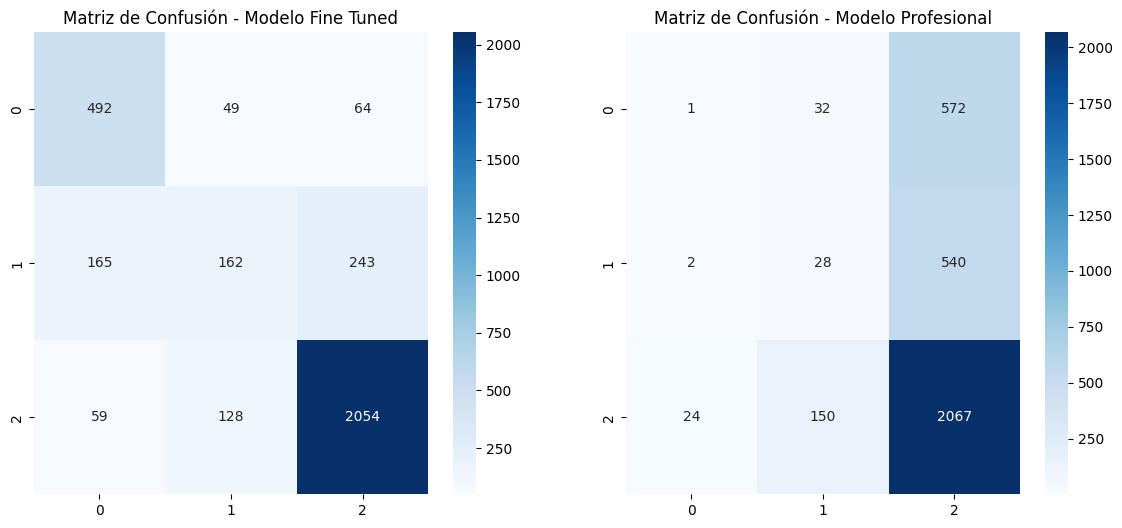

Diferencia de Precisión: 0.3168
Diferencia de Recall: 0.1792
Diferencia de F1-Score: 0.2641
Diferencia de Accuracy: 0.1792


In [ ]:
# Utilización de las funciones con los modelos

# Evaluación del modelo fine-tuned
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fine_tuned_model = BertForSequenceClassification.from_pretrained(
    config.pretrained_model,
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)
fine_tuned_model.load_state_dict(torch.load(f'/content/drive/MyDrive/hotel/_BERT_epoch_2.model'))
fine_tuned_model.to(config.device)

results_fine_tuned = ErrorAnalysis(dataloader_validation, config, fine_tuned_model)

# Evaluación del modelo finetuned
finetuned_model = BertForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
    ignore_mismatched_sizes=True
)
finetuned_model.to(config.device)

results_finetuned = ErrorAnalysis(dataloader_validation, config, finetuned_model)

# Comparación de ambos modelos
ModelComparation(results_fine_tuned, results_finetuned, "Fine Tuned", "Profesional")